In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [3]:
# from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
# from pts.model.transformer_tempflow import TransformerTempFlowEstimator
# from pts import Trainer
from pytorch_lightning import Trainer

In [4]:
from diffusers import (
    PNDMScheduler,
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    KDPM2DiscreteScheduler,
    DEISMultistepScheduler,
)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [7]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

In [8]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset = get_dataset("electricity_nips", regenerate=False)

In [9]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [10]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

In [11]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [12]:
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)

In [13]:
estimator = TimeGradEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length * 3,
    freq=dataset.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=20, devices="1"),
)

In [14]:
predictor = estimator.train(dataset_train, num_workers=8)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type          | Params | In sizes | Out sizes        
-----------------------------------------------------------------------
0 | model | TimeGradModel | 432 K  | ?        | [1, 100, 24, 370]
-----------------------------------------------------------------------
432 K     Trainable params
0         Non-trainable params
432 K     Total params
1.729     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.34740 (best 0.34740), saving model to '/Users/kwunyingzhou/timegrad-s4/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.09696 (best 0.09696), saving model to '/Users/kwunyingzhou/timegrad-s4/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.06702 (best 0.06702), saving model to '/Users/kwunyingzhou/timegrad-s4/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 0.05679 (best 0.05679), saving model to '/Users/kwunyingzhou/timegrad-s4/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 0.05101 (best 0.05101), saving model to '/Users/kwunyingzhou/timegrad-s4/lightning_logs/version_1/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 0.04600 (b

In [15]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

In [16]:
forecasts = list(forecast_it)
targets = list(ts_it)

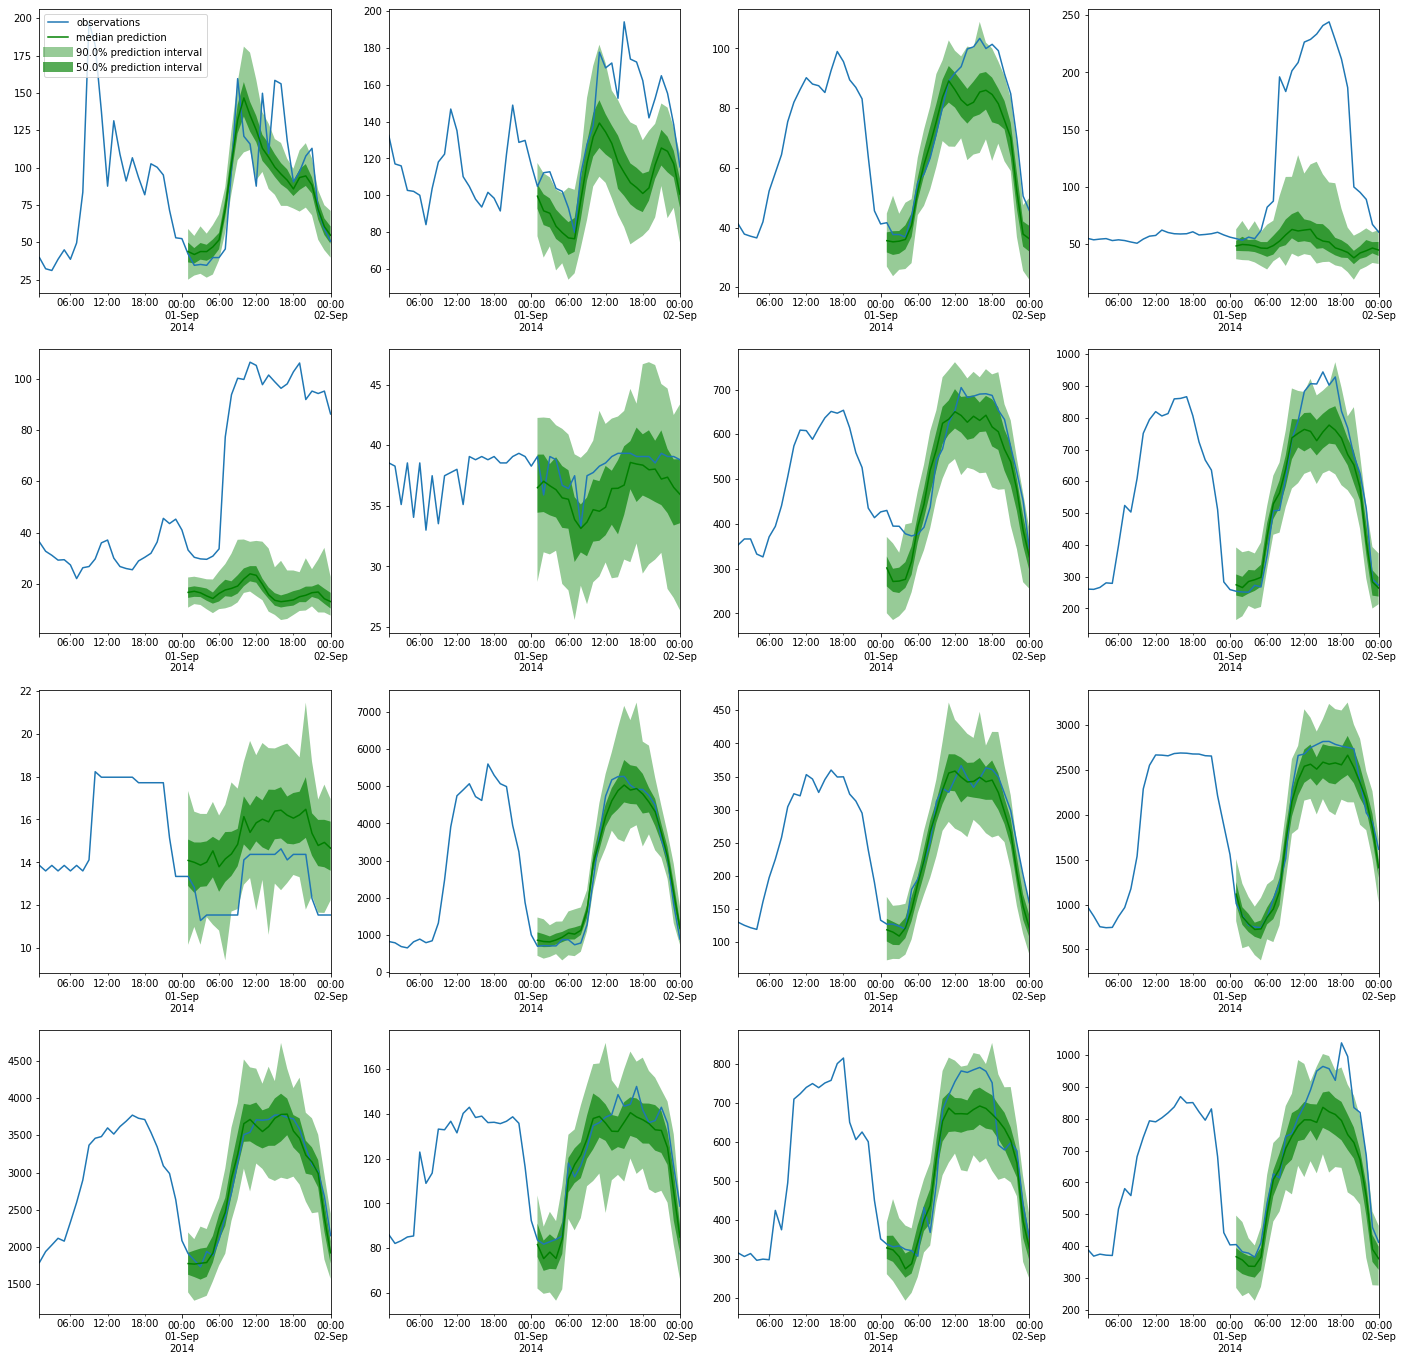

In [17]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

In [18]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [19]:
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 89.81it/s]
Running evaluation: 7it [00:00, 129.00it/s]
Running evaluation: 7it [00:00, 119.02it/s]
Running evaluation: 7it [00:00, 125.62it/s]
Running evaluation: 7it [00:00, 125.28it/s]
Running evaluation: 7it [00:00, 123.69it/s]
Running evaluation: 7it [00:00, 121.32it/s]
Running evaluation: 7it [00:00, 126.78it/s]
Running evaluation: 7it [00:00, 119.29it/s]
Running evaluation: 7it [00:00, 118.75it/s]
Running evaluation: 7it [00:00, 126.88it/s]
Running evaluation: 7it [00:00, 126.68it/s]
Running evaluation: 7it [00:00, 110.98it/s]
Running evaluation: 7it [00:00, 94.15it/s]
Running evaluation: 7it [00:00, 90.58it/s]
Running evaluation: 7it [00:00, 110.22it/s]
Running evaluation: 7it [00:00, 122.76it/s]
Running evaluation: 7it [00:00, 117.24it/s]
Running evaluation: 7it [00:00, 123.43it/s]
Running evaluation: 7it [00:00, 120.28it/s]
Running evaluation: 7it [00:00, 126.66it/s]
Running evaluation: 7it [00:00, 119.65it/s]
Running evaluation: 7it [00:00, 114

In [20]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

CRPS: 0.08424941525717067
ND: 0.10891852326309058
NRMSE: 0.894793435083521

CRPS-Sum: 0.043186007671784425
ND-Sum: 0.05814156381427675
NRMSE-Sum: 0.07074610412482524
